# Final Project: Analyzing Connectomes in a Cat

***

**Name**: Teddy Heckelman and Keyin Huang


***


In [2]:
############## IMPORTS #################
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [3]:
data = [1, 2, 3, 4, 5]

# Sum the elements in the list
total = sum(data)

In [4]:
fname = 'mixed.species_brain_1.graphml'
print(f'reading the network file : {fname}\n')
G = nx.read_graphml('./' + fname) 

reading the network file : mixed.species_brain_1.graphml



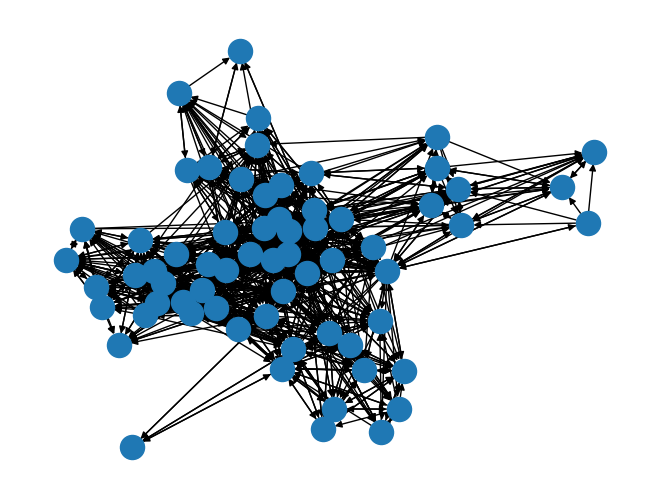

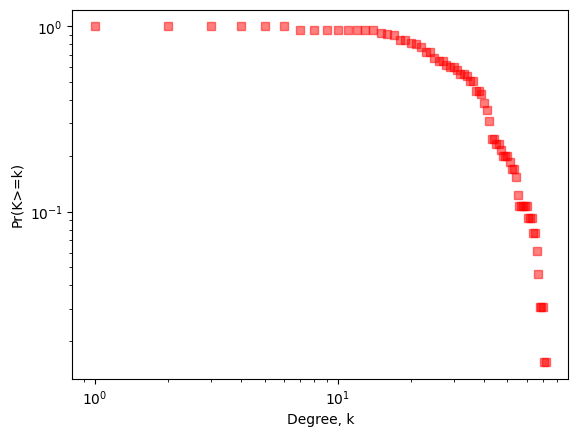

number of nodes, n  = 65
number of edges, m  = 1139
mean degree,    <k> = 35.05
clustering coefficient, C     =  0.47
mean geodesic distance, <ell> =  1.86


In [5]:
s = nx.draw(G, pos = nx.spring_layout(G))
plt.show(s) #spring
n = G.number_of_nodes()
m = G.number_of_edges()
kmean = 2*m/n
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)
l = sorted(G.degree, key=lambda x: x[1], reverse=True)
list_of_degrees = []
for i in range(len(l)):
    list_of_degrees.append(l[i][1])
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

plot_CCDF(list_of_degrees)



print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)



### Part 1: Rich Club Analysis:

* Compute the degree distribution of the network to determine the rich club regime.
* Calculate the rich club coefficient for different levels of connectivity (k) and compare it with null models to establish rich club organization.
* Identify the top-ranking nodes to form the rich club based on predetermined criteria (top 15 highest-degree nodes).


In [6]:
#compute phi
def compute_phi(G): 
    e = G.number_of_edges()
    n = G.number_of_nodes()
    phi = 0
    if e != 0 and n != 0 and n!= 1:
        phi = e / (n * (n-1))
    else:
        phi = 0
    return phi

In [7]:
#takes in G: a directed unweighted graph
#take sin k, the threshold
#computes in and out degree 
#take nodes where their in and out degree = k
#return subgraph with those nodes
def create_subgraph(k, G):
    subgraph_nodes = []
    for node in nx.nodes(G):
        in_out_count = G.in_degree(node) + G.out_degree(node)
        if in_out_count > k:
            subgraph_nodes.append(node)
    return subgraph_nodes, G.subgraph(subgraph_nodes)


# takes in graph
# returns a tuple: (list of subgraph, list of phi)
# wrapper for create subgraph and create phi function
def subgraph_phi(G, K):
    s_k = [] #nodes in each k 1-68
    phi_k = []
    for k in range(K):
        nodes, subgraph = create_subgraph(k,G)
        s_k.append(nodes)
        phi = compute_phi(subgraph)
        if phi != 0:
            phi_k.append(compute_phi(subgraph))
    return s_k, phi_k


In [8]:
def get_avg(l,k):
    total = 0
    count = 0
    for list in l:
        if len(list) > k:
            count += 1
            total += list[k] 
    return total/count

def compute_ratio(rand_phis, emp_phis):
    ratio = []
    random_avg = []
    for k in range(68):
        random_avg.append(get_avg(rand_phis, k))
    
    for i in range(68):
        rate = emp_phis[i]/random_avg[i]
        ratio.append(rate)
        
    
    return ratio

In [9]:
import random
# create subgraph and phi for empirical data
def compute_phi_empirical(K, G):
    graphs, emp_phis = subgraph_phi(G, K)
    return graphs, emp_phis


# create subgraph and phi for random data
def compute_phi_random(K, G, nrep):
    rand_phis = []
    out_degrees = [d for n, d in G.out_degree()]
    in_degrees = [d for n, d in G.in_degree()]


    for i in range(nrep): # creating nrep random graphs, 68 subgraphs each
        random.seed(i)
        phi = []
        null_graph = nx.directed_configuration_model(in_degree_sequence=in_degrees, out_degree_sequence=out_degrees)
        _, phi = subgraph_phi(null_graph, K)
        rand_phis.append(phi)
    
    return rand_phis

def null_graph_generator(G):
    
    iterate = 1
    G_NULL = nx.DiGraph(G)

    while iterate <= (20*m):

        random_edge_1 = random.choice(list(G_NULL.edges()))
        a, b = random_edge_1

        random_edge_2 = random.choice(list(G_NULL.edges()))
        c, d = random_edge_2

        if a==d or b==c or a==b or c==d:
            break
        else: #swap edge
            #print('here')
            iterate += 1
            G_NULL.remove_edge(a,b)
            G_NULL.add_edge(a,d)
            G_NULL.remove_edge(c,d)
            G_NULL.add_edge(c,b)

    return G_NULL

                

# pair of directed edges
# (a,b) (c,d) a= d then self loop -> reject -> pick a different pair 20m number of times
# (a,d) (c,b)
# (a->b) (c->d)
# replace : (a->d) (c->b)
#check self loop and mutli - edge
#if a = d
# constraits: not every swap allowed -> 
# constraits:a==d or b==c or a==b or c==d reject and choose new pair (no self-loops no multi-edges) 


In [10]:
import random
###
K = 68
nrep = 200
###

nodes_k, empirical_phi = compute_phi_empirical(K, G)
random_phi = compute_phi_random(K, G, nrep)
ratio = compute_ratio(random_phi, empirical_phi)


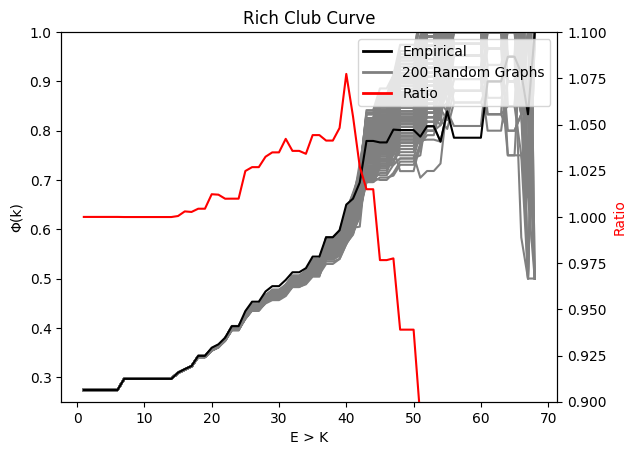

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


for i in range(len(random_phi)):
    x_values = list(range(1, len(random_phi[i])+1))
    ax1.plot(x_values, random_phi[i], color='gray')

empirical_x_vals = list(range(1, 69))
ax1.plot(empirical_x_vals, empirical_phi, color='black')
ax2.plot(empirical_x_vals, ratio, color='r')

ax1.set_xlabel('E > K')
ax1.set_ylabel('Φ(k)', color='black')
ax2.set_ylabel('Ratio', color='r')

ax1.set_ylim(0.25, 1)
ax2.set_ylim(0.9, 1.1)
plt.title('Rich Club Curve')

legend_entries = [
    plt.Line2D([0], [0], color='black', lw=2, label='Empirical'),
    plt.Line2D([0], [0], color='gray', lw=2, label='200 Random Graphs'),
    plt.Line2D([0], [0], color='red', lw=2, label='Ratio')
]

# Add the legend with specified entries
plt.legend(handles=legend_entries)

plt.show()



In [12]:
print(len(nodes_k))

68


In [13]:
### Selecting 15 rich club nodes ###

#indexed_list is a tuple conatining the value of ratio and the index or rather (k)
indexed_list = [(value, index) for index, value in enumerate(ratio)]

# sort the list in descending order
sorted_indices = sorted(indexed_list, key=lambda x: x[0], reverse=True)

# Extract the highest ratio and its index
top_15_ratio = [index for value, index in sorted_indices[:15]]


node_degrees = {}
total = 0

#obtain the sum of in and out degress of the nodes within the threshold k=39 where ratio is the highest
for n in nodes_k[39]:
    total = 0
    total = G.in_degree(n) + G.out_degree(n)
    node_degrees[n] = total

#sort the nodes list in descending order based its value
sorted_keys = sorted(node_degrees, key=lambda x: node_degrees[x], reverse=True)

# Extract the top 15 degree nodes where ratio is at its highest
rich_club_nodes = sorted_keys[:15]
print(rich_club_nodes)

all_nodes = list(G.nodes())
non_rich_nodes = list(set(all_nodes) - set(rich_club_nodes))
print(len(non_rich_nodes))
    

['n52', 'n58', 'n15', 'n50', 'n59', 'n51', 'n14', 'n37', 'n11', 'n54', 'n26', 'n40', 'n47', 'n53', 'n25']
50


Discuss evidence of rich club hubs: <br><br>
Part one focuses on proving the precense of rich club hubs which are relatively small but crucial set of highly connected regions that play a central role in the overall architecture of brain networks. In order to prove this, there needs to be a range of nodes that are highly connected. Since we know high degree nodes are dense and highly connected, we made a subgraph consisting of the top 15 highest-degree nodes and compared it to the Erdos-Renyi and Chung-Lu graph. As expected, the clustering coefficent is much higher than the normalized coefficient in the Erdos-Renyi graph, proving a highly connected and dense hub, in other words, the rich club hub. 


### Part 2: Functional Module Identification:
* Use the provided functional categorization of cortical regions to classify nodes into distinct functional modules (visual, auditory, somatomotor, 
* frontolimbic).
* Apply community detection algorithms to verify the initial module classification and potentially refine it based on network connectivity patterns.


In [14]:
VisualRows = [0,15]
# VisualColumn = [47, 65]
AudRows = [16, 26]
# AudColumn= [37, 57]
StomRows = [27, 44]
# StomColumn = [19, 36]
FrontoRows = [45, 65]
# FrontoColumn = [0, 18]
A = nx.adjacency_matrix(G)
A = A.toarray()
def functional_modules(A, VisualRows, AudRows, StomRows, FrontoRows):
    z = {}
    for i in range(A.shape[0]):  
        for j in range(A.shape[1]): 
            if VisualRows[0] <= i <= VisualRows[1] and VisualRows[0] <= j <= VisualRows[1]:
                z[f'n{i}'] = "Visual"  
                z[f'n{j}'] = "Visual"
            elif AudRows[0] <= i <= AudRows[1] and AudRows[0] <= j <= AudRows[1]:
                z[f'n{i}'] = "Auditory"   
                z[f'n{j}'] = "Auditory"   
            elif StomRows[0] <= i <= StomRows[1] and StomRows[0] <= j <= StomRows[1]:
                z[f'n{i}'] = "Somatomotor"   
                z[f'n{j}'] = "Somatomotor" 
            elif FrontoRows[0] <= i <= FrontoRows[1] and FrontoRows[0] <= j <= FrontoRows[1]:
                z[f'n{i}'] = "Frontolimbic"   
                z[f'n{j}'] = "Frontolimbic"
            
    return z
z = functional_modules(A, VisualRows, AudRows, StomRows, FrontoRows)
print(z)

{'n0': 'Visual', 'n1': 'Visual', 'n2': 'Visual', 'n3': 'Visual', 'n4': 'Visual', 'n5': 'Visual', 'n6': 'Visual', 'n7': 'Visual', 'n8': 'Visual', 'n9': 'Visual', 'n10': 'Visual', 'n11': 'Visual', 'n12': 'Visual', 'n13': 'Visual', 'n14': 'Visual', 'n15': 'Visual', 'n16': 'Auditory', 'n17': 'Auditory', 'n18': 'Auditory', 'n19': 'Auditory', 'n20': 'Auditory', 'n21': 'Auditory', 'n22': 'Auditory', 'n23': 'Auditory', 'n24': 'Auditory', 'n25': 'Auditory', 'n26': 'Auditory', 'n27': 'Somatomotor', 'n28': 'Somatomotor', 'n29': 'Somatomotor', 'n30': 'Somatomotor', 'n31': 'Somatomotor', 'n32': 'Somatomotor', 'n33': 'Somatomotor', 'n34': 'Somatomotor', 'n35': 'Somatomotor', 'n36': 'Somatomotor', 'n37': 'Somatomotor', 'n38': 'Somatomotor', 'n39': 'Somatomotor', 'n40': 'Somatomotor', 'n41': 'Somatomotor', 'n42': 'Somatomotor', 'n43': 'Somatomotor', 'n44': 'Somatomotor', 'n45': 'Frontolimbic', 'n46': 'Frontolimbic', 'n47': 'Frontolimbic', 'n48': 'Frontolimbic', 'n49': 'Frontolimbic', 'n50': 'Frontolim

### Part 3: Node Classification:
* betweeness and pagerank


In [15]:
betweeness = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)
def compute_null_betweness(G, nrep):
    out_degrees = [d for n, d in G.out_degree()]
    in_degrees = [d for n, d in G.in_degree()]
    rnd_betweeness = []
    rnd_pagerank = []

    for i in range(nrep):
        random.seed(i)
        null_graph = nx.directed_configuration_model(in_degree_sequence=in_degrees, out_degree_sequence=out_degrees)
        rnd_betweeness.append(nx.betweenness_centrality(null_graph))
        rnd_betweeness.append(nx.pagerank(null_graph))
    
    return rnd_betweeness, rnd_pagerank
print(betweeness)
print(pagerank)

{'n0': 0.0003166228612657184, 'n1': 0.0015225206522074708, 'n2': 0.02049517260053045, 'n3': 0.007497791403825829, 'n4': 0.014181897400199053, 'n5': 0.01701291783355258, 'n6': 0.0044084159936783615, 'n7': 0.0018686500665653428, 'n8': 0.0010142190528840307, 'n9': 0.004592929760467666, 'n10': 0.005933578310535182, 'n11': 0.04342482237278226, 'n12': 0.014990371428656484, 'n13': 3.543083900226757e-05, 'n14': 0.052153733342408644, 'n15': 0.07016766737395473, 'n16': 0.0008418060368697386, 'n17': 0.006605269181763345, 'n18': 0.008160226692066973, 'n19': 0.009724314948222616, 'n20': 0.000716990954303667, 'n21': 0.0030003190826817555, 'n22': 0.011043263170369655, 'n23': 0.0014355621283741557, 'n24': 0.0, 'n25': 0.018349533703837774, 'n26': 0.06384469278750944, 'n27': 0.0014498058372667021, 'n28': 0.00121071248727243, 'n29': 0.0022898174026193467, 'n30': 0.0005959083750231, 'n31': 0.0014253379117826397, 'n32': 0.00945211416093943, 'n33': 0.00631076245446858, 'n34': 0.007911218814831958, 'n35': 0.

Discuss our findings of the inter and intramodule nodes and what this says about the architecture of the network and how information is passed.

### Part 4: Connectivity Profile: (Keyin)



In [16]:
# Rich Hub Distribution
visual_count = 0
fronto_count = 0
auditory_count = 0
soma_count = 0

visual_count_nr = 0
fronto_count_nr = 0
auditory_count_nr = 0
soma_count_nr = 0

for node in rich_club_nodes:
    module = z[node]
    if module == "Visual":
        visual_count += 1
    elif module == "Frontolimbic":
        fronto_count += 1
    elif module == "Auditory":
        auditory_count += 1
    elif module == "Somatomotor":
        soma_count += 1


for node in non_rich_nodes:
    module = z[node]
    if module == "Visual":
        visual_count_nr += 1
    elif module == "Frontolimbic":
        fronto_count_nr += 1
    elif module == "Auditory":
        auditory_count_nr += 1
    elif module == "Somatomotor":
        soma_count_nr += 1




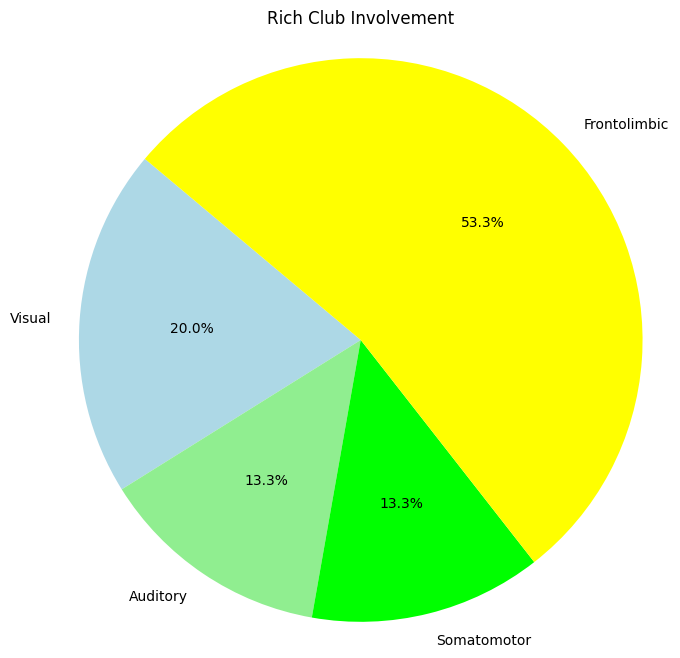

In [102]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Visual', 'Auditory', 'Somatomotor', 'Frontolimbic']
sizes = [visual_count, auditory_count, soma_count, fronto_count]  
colors = ['lightblue', 'lightgreen', 'lime', 'yellow']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Rich Club Involvement')
plt.show()

In [18]:
#rich nodes vs non rich nodes

rich_dist = [visual_count, auditory_count, soma_count, fronto_count]
non_rich_dist = [visual_count_nr, auditory_count_nr, soma_count_nr, fronto_count_nr]

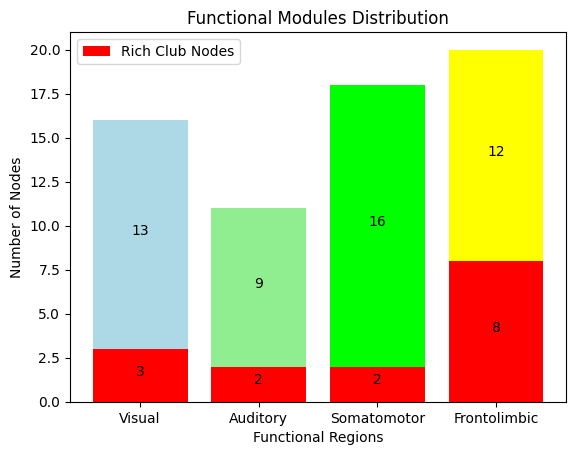

In [106]:
import networkx as nx
import matplotlib.pyplot as plt


# Define labels for the x-axis
labels = ['Visual', 'Auditory', 'Somatomotor', 'Frontolimbic']
colors_non_rich = ['lightblue', 'lightgreen', 'lime', 'yellow']

# Define positions for the bars
x = range(len(labels))

# Plotting the bar graph
plt.bar(x, rich_dist, color='red', label='Rich Club Nodes')
plt.bar(x, non_rich_dist, bottom=rich_dist, color=colors_non_rich,)

# Adding labels and title
plt.xlabel('Functional Regions')
plt.ylabel('Number of Nodes')
plt.title('Functional Modules Distribution')

# Adding legend
plt.legend()

# Adding x-axis tick labels
plt.xticks(x, labels)

# Adding labels on the bars
for i in range(len(labels)):
    plt.text(x[i], rich_dist[i] / 2, str(rich_dist[i]), ha='center', color='black', fontsize=10)
    plt.text(x[i], rich_dist[i] + non_rich_dist[i] / 2, str(non_rich_dist[i]), ha='center', color='black', fontsize=10)

# Show the plot
plt.show()


In [20]:
print(G.degree())

[('n0', 17), ('n1', 22), ('n2', 39), ('n3', 30), ('n4', 38), ('n5', 36), ('n6', 25), ('n7', 17), ('n8', 14), ('n9', 25), ('n10', 24), ('n11', 54), ('n12', 44), ('n13', 6), ('n14', 60), ('n15', 67), ('n16', 21), ('n17', 31), ('n18', 19), ('n19', 27), ('n20', 14), ('n21', 19), ('n22', 24), ('n23', 15), ('n24', 6), ('n25', 46), ('n26', 53), ('n27', 17), ('n28', 22), ('n29', 28), ('n30', 22), ('n31', 24), ('n32', 36), ('n33', 40), ('n34', 39), ('n35', 39), ('n36', 42), ('n37', 55), ('n38', 16), ('n39', 36), ('n40', 51), ('n41', 42), ('n42', 42), ('n43', 41), ('n44', 41), ('n45', 40), ('n46', 36), ('n47', 50), ('n48', 41), ('n49', 42), ('n50', 66), ('n51', 63), ('n52', 72), ('n53', 47), ('n54', 54), ('n55', 31), ('n56', 33), ('n57', 27), ('n58', 70), ('n59', 65), ('n60', 21), ('n61', 20), ('n62', 34), ('n63', 6), ('n64', 34)]


In [88]:
# Z-Score
def calculate_DegreezScore_in_out(G,i):
    # This function calculates the degree z-score of node i, given graph G
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : i, a node in G
    # output : z_i, the degree z-score
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 5 lines, plus return)
    n = G.number_of_nodes()
    kmean = sum(dict(G.in_degree()).values()) / n
    dev = np.std(list(dict(G.in_degree()).values()), ddof=1)
    z_in = (G.in_degree(i) - kmean) / dev

    kmean = sum(dict(G.out_degree()).values()) / n
    dev = np.std(list(dict(G.out_degree()).values()), ddof=1)
    z_out = (G.out_degree(i) - kmean) / dev


    return z_in, z_out

#Participation Score:
def calculate_Participation_in_out(G,z,i):
    # This function calculates the participation coefficient of node i, given graph G and partition z
    #
    # input  : G, anetworkx simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes
    #        : i, a node in G
    # output : P_i, the participation coefficient
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ### YOUR CODE (my code: 9 lines, plus return)
    in_neighbors = list(G.predecessors(i))
    c = set(z.values())
    s = 0
    sums = []
    for r in c:
        s = 0
        for j in in_neighbors:
            if z[j] == r: 
                s += 1
        s = (s/len(in_neighbors)) ** 2
        sums.append(s)
    p_in = 1 - sum(sums)

    #p out
    out_neighbors = list(G.successors(i))
    c = set(z.values())
    s = 0
    sums = []
    for r in c:
        s = 0
        for j in out_neighbors:
            if z[j] == r: 
                s += 1
        s = (s/len(out_neighbors)) ** 2
        sums.append(s)
    p_out = 1 - sum(sums)

    return p_in, p_out

def all_zscores(G):
    zinscores = {}
    zoutscores = {}
    for node in G.nodes():
        z_in, z_out = calculate_DegreezScore_in_out(G, node)
        zinscores[node] = z_in
        zoutscores[node] = z_out
    return zinscores, zoutscores
        
def all_pscores(G, z):
    pinscores = {}
    poutscores = {}
    for node in G.nodes():
        p_in, p_out = calculate_Participation_in_out(G, z, node)
        pinscores[node] = p_in
        poutscores[node] = p_out
    return pinscores, poutscores


def top_15_zscore(G):
    zinscores, zoutscores = all_zscores(G)
    sorted_in_scores = sorted(zinscores.items(), key=lambda x: x[1], reverse=True)
    sorted_out_scores = sorted(zoutscores.items(), key=lambda x: x[1], reverse=True)
    # Get the top 15 items
    top_in = sorted_in_scores[:15]
    # Extract keys from the top 15 items
    top_in = [item[0] for item in top_in]

    top_out = sorted_out_scores[:15]
    # Extract keys from the top 15 items
    top_out = [item[0] for item in top_out]

    return top_in ,top_out

def top_15_pscore(G, z):
    pinscores, poutscores = all_pscores(G, z)
    sorted_in_scores = sorted(pinscores.items(), key=lambda x: x[1], reverse=True)
    sorted_out_scores = sorted(poutscores.items(), key=lambda x: x[1], reverse=True)

    # Get the top 15 items
    top_in = sorted_in_scores[:15]
    # Extract keys from the top 15 items
    top_in = [item[0] for item in top_in]

    top_out = sorted_out_scores[:15]
    # Extract keys from the top 15 items
    top_out = [item[0] for item in top_out]

    return top_in, top_out

def top_15_out_degree(G):
    out_degrees = {node: G.out_degree(node) for node in G.nodes()}

    # Sort the nodes based on their out degree in descending order
    sorted_nodes = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)

    # Get the top 15 nodes with the highest out degree
    top_15_nodes = [node for node, _ in sorted_nodes[:15]]  # Extracting only the node names
    return top_15_nodes

def top_15_in_degree(G):
    in_degrees = {node: G.in_degree(node) for node in G.nodes()}

    # Sort the nodes based on their in degree in descending order
    sorted_nodes = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)

    # Get the top 15 nodes with the highest in degree
    top_15_nodes = [node for node, _ in sorted_nodes[:15]]  # Extracting only the node names
    return top_15_nodes



def rank(node, zin, zout, pin, pout):
    rank = 0 
    if node in zin:
        rank += 1
    if node in zout:
        rank += 1
    if node in pin:
        rank += 1
    if node in pout:
        rank += 1
    return rank

In [89]:
zin, zout = calculate_Participation_in_out(G,z,'n6')
print(zin)
print(zout)

0.6953125
0.49382716049382713


In [90]:
### Get 15 Highest Score For Each Metric ###
top_zinscores, top_zoutscores = top_15_zscore(G)
top_pinscores, top_poutscores = top_15_pscore(G, z)
top_in_score = top_15_in_degree(G)
top_out_score = top_15_out_degree(G)


In [91]:
### Rank Each Node ###

# format {0: [], 1: [], 2: [], 3: [], 4: []}
rich_ranks = {key: [] for key in range(5)}
non_rich_ranks = {key: [] for key in range(5)}

for node in rich_club_nodes:
    ranking = rank(node, top_zinscores, top_zoutscores, top_pinscores,  top_poutscores)
    rich_ranks[ranking].append(node)

for node in non_rich_nodes:
    ranking = rank(node, top_zinscores, top_zoutscores, top_pinscores,  top_poutscores)
    non_rich_ranks[ranking].append(node)

print(rich_ranks)
print(non_rich_ranks)

{0: [], 1: ['n54', 'n53'], 2: ['n40', 'n47', 'n25'], 3: ['n59', 'n37', 'n11'], 4: ['n52', 'n58', 'n15', 'n50', 'n51', 'n14', 'n26']}
{0: ['n28', 'n21', 'n0', 'n20', 'n8', 'n13', 'n24', 'n41', 'n18', 'n22', 'n46', 'n19', 'n44', 'n10', 'n1', 'n7', 'n35', 'n45', 'n55', 'n39', 'n32', 'n48', 'n23', 'n30', 'n56', 'n60', 'n27', 'n17', 'n34', 'n29', 'n61', 'n62', 'n9', 'n63', 'n57', 'n3', 'n31', 'n43'], 1: ['n2', 'n33', 'n49', 'n5', 'n6', 'n36', 'n38', 'n16', 'n64'], 2: ['n42', 'n12', 'n4'], 3: [], 4: []}


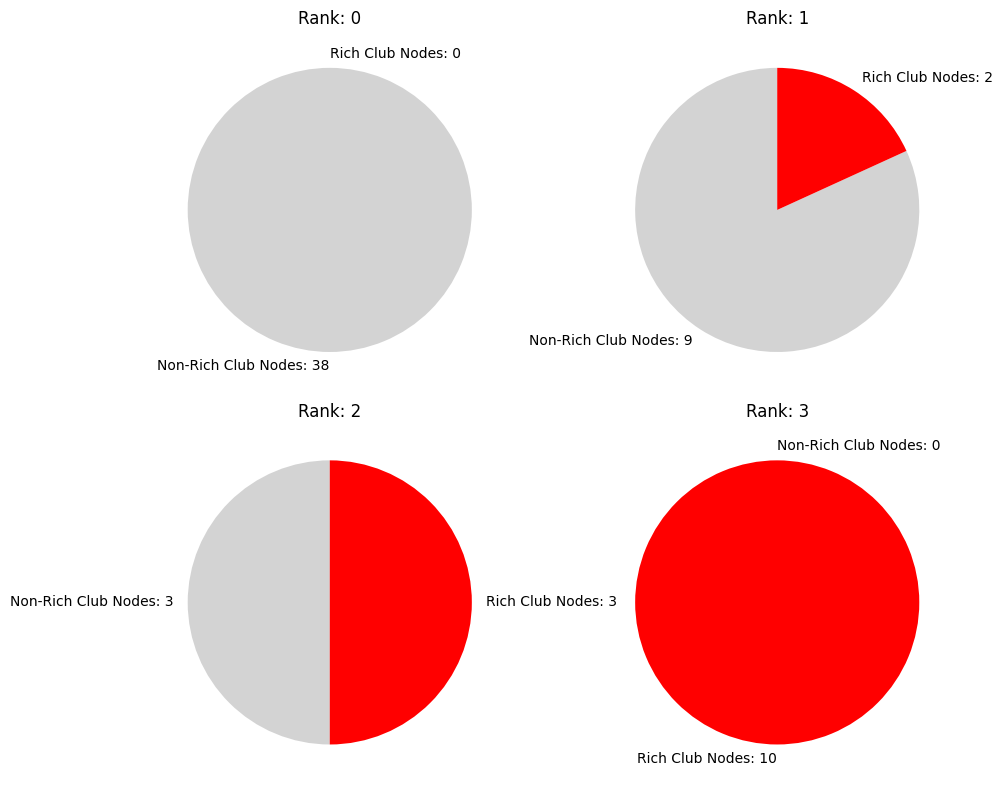

In [105]:

# Data for the pie chart
extra = len(non_rich_ranks[3]) + len(non_rich_ranks[4])
extra2 = len(rich_ranks[3]) + len(rich_ranks[4])

sizes = [[len(non_rich_ranks[0]), len(rich_ranks[0])], 
         [len(non_rich_ranks[1]), len(rich_ranks[1])], 
         [len(non_rich_ranks[2]), len(rich_ranks[2])], 
         [extra, extra2] ]
 
labels = [['Non-Rich Club Nodes: ' + str(len(non_rich_ranks[0])), 'Rich Club Nodes: ' + str(len(rich_ranks[0]))],
          ['Non-Rich Club Nodes: ' + str(len(non_rich_ranks[1])), 'Rich Club Nodes: ' + str(len(rich_ranks[1]))],
          ['Non-Rich Club Nodes: ' + str(len(non_rich_ranks[2])), 'Rich Club Nodes: ' + str(len(rich_ranks[2]))],
          ['Non-Rich Club Nodes: ' + str(extra), 'Rich Club Nodes: ' + str(extra2)]]
colors = ['lightgrey', 'red'] 
# Create a pie chart
# Create a figure with 2x2 subplots
plt.figure(figsize=(10, 8))

for i in range(4):
    # Add a subplot at position (i+1)
    plt.subplot(2, 2, i+1)
    
    # Create a pie chart
    plt.pie(sizes[i], labels=labels[i], colors=colors, startangle=90)
    
    # Add a title
    plt.title(f'Rank: {i}')


# Adjust layout
plt.tight_layout()

# Display the figure
plt.show()

In [95]:
### Statistics


#rich club
z_pairs_r = []
p_pairs_r = []
in_out_pairs_r = []

#non-rich club
z_pairs_nr = []
p_pairs_nr = []
in_out_pairs_nr = []

for i in G.nodes:
    p_in, p_out = calculate_Participation_in_out(G, z, i)
    z_in, z_out = calculate_DegreezScore_in_out(G, i)
    in_degree = G.in_degree(i)
    out_degree = G.out_degree(i)

    if i in rich_club_nodes:
        z_pairs_r.append((z_in, z_out))
        p_pairs_r.append((p_in,p_out))
        in_out_pairs_r.append((in_degree, out_degree))
    else:
        z_pairs_nr.append((z_in, z_out))
        p_pairs_nr.append((p_in,p_out))
        in_out_pairs_nr.append((in_degree, out_degree))


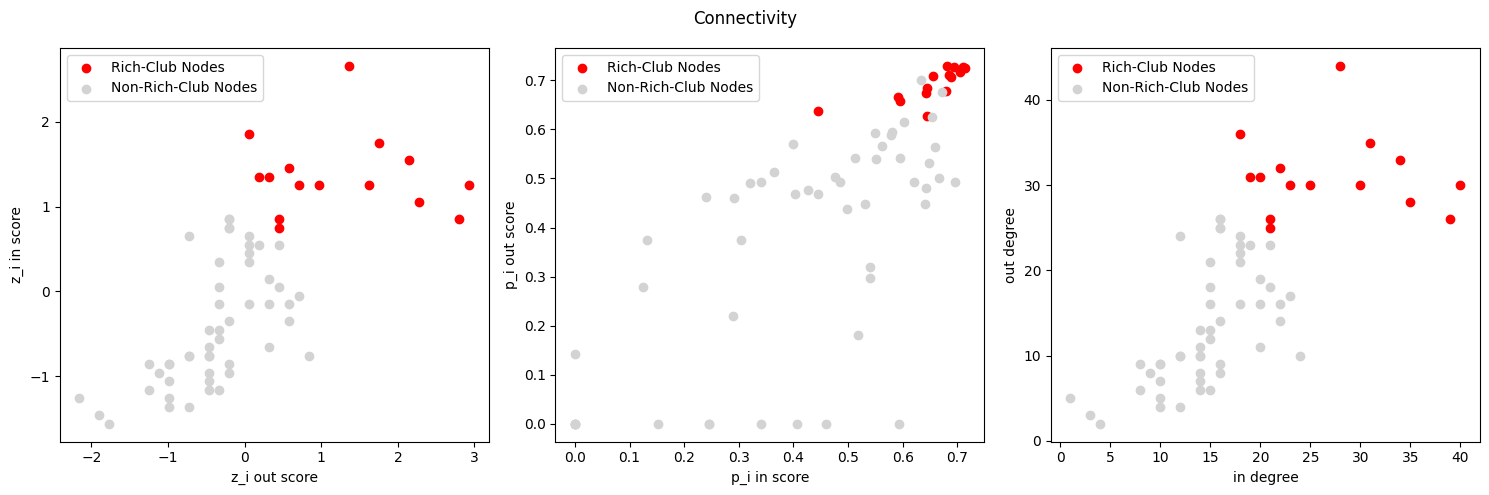

In [96]:
import matplotlib.pyplot as plt


# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each scatter plot on its own subplot
in_val = [pair[0] for pair in z_pairs_r] 
out_val = [pair[1] for pair in z_pairs_r]
axs[0].scatter(in_val, out_val, color='red', label='Rich-Club Nodes')

in_val = [pair[0] for pair in z_pairs_nr] 
out_val = [pair[1] for pair in z_pairs_nr]
axs[0].scatter(in_val, out_val, color='lightgray', label='Non-Rich-Club Nodes')

in_val = [pair[0] for pair in p_pairs_r] 
out_val = [pair[1] for pair in p_pairs_r]
axs[1].scatter(in_val, out_val, color='red', label='Rich-Club Nodes')

in_val = [pair[0] for pair in p_pairs_nr] 
out_val = [pair[1] for pair in p_pairs_nr]
axs[1].scatter(in_val, out_val, color='lightgray', label='Non-Rich-Club Nodes')

in_val = [pair[0] for pair in in_out_pairs_r] 
out_val = [pair[1] for pair in in_out_pairs_r]
axs[2].scatter(in_val, out_val, color='red', label='Rich-Club Nodes')

in_val = [pair[0] for pair in in_out_pairs_nr] 
out_val = [pair[1] for pair in in_out_pairs_nr]
axs[2].scatter(in_val, out_val, color='lightgray', label='Non-Rich-Club Nodes')

# Add labels and title to each subplot

axs[0].set_xlabel('z_i out score')
axs[0].set_ylabel('z_i in score')

axs[1].set_xlabel('p_i in score')
axs[1].set_ylabel('p_i out score')

axs[2].set_xlabel('in degree')
axs[2].set_ylabel('out degree')

# Add title for the entire figure
plt.suptitle('Connectivity')

# Add legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Discuss our findings and what is says about the importance of global network communication

### Part 5: Path Motif Analysis:
* Compute all shortest communication paths in the network and label them with categories of connections (rich club, feeder, local).
* Determine the prevalence of each unique sequence of connections (path motifs) to understand the organization of communication pathways.
* Compare path motif counts with those in randomized networks to assess significance.


Discuss the correlation between type of connection (rich club, feeder, local) and its communcation. what does the correlation tell us about the architerture and how communication is passed.

### Part 6: Statistical Analysis: (for presentation)
* Perform permutation testing to assess statistical significance of group differences on node and connection metrics.
* Evaluate the structural homogeneity and module diversity of connections to understand their role in network organization.


### Part 7: Visualization and Interpretation: (for presentation)
* Visualize the network structure, rich club nodes, functional modules, and communication pathways to gain insights into the organization of the cat brain network.
* Interpret the findings in the context of existing literature and theoretical frameworks related to brain network organization.
